#Classification Of Skin Lesions By Topological Data AnalysisAlongside With Neural Network [Paper Link](https://www.techrxiv.org/articles/preprint/Classification_Of_Skin_Lesions_By_Topological_Data_Analysis_Alongside_With_Neural_Network/12628088)


Authors:
* Naiereh Elyasi*
* Mehdi Hosseini Moghadam**

\* Department of math and computer Sciences, Kharazmi University, Taleghani street, Tehran, Iran

** Department of Engineering, Kharazmi University, Taleghani street, Tehran, Iran



**This notebook  provides the supplementary code for the above article**

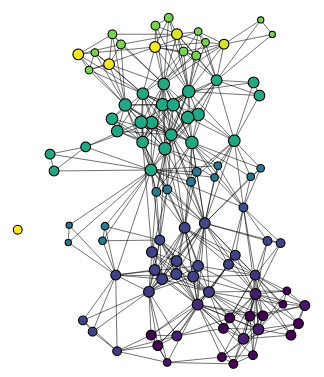

#Abstract               

In this paper we use TDA mapper alongside with deep convolutional neural networks in the classification of 7 major skin diseases. First we apply kepler mapper with neural network as one of its filter steps to classify the dataset HAM10000. Mapper visualizes the classification result by a simplicial complex, where neural network can not do this alone, but as a filter step neural network helps to classify data better. Furthermore we apply TDA mapper and persistent homology to understand the weights of layers of mobilenet network in different training epochs of HAM10000. Also we use persistent diagrams to visualize the results of analysis of layers of mobilenet network.

In [ ]:
# first you need connect to kaggle library in order to download the dataset  
#Install kaggle library
!pip install kaggle
#Make a directory called .kaggle which makes it invisible
!mkdir .kaggle 
import json
token = {"username":"********","key":"***************************"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
   
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

#Data

In this paper we have used the data set HAM10000 .There are a total of 10015 dermatoscopic images of skinlesions labeled with their respective types of skin diseases.The images in the data set are separated into the followingseven types of skin diseases:

* Actinic keratosis is considered to be a noncancerous(benign) type of skin diseases. However, if left un-treated, it usually develops into squamous cell carci-noma (SCC).

* Basal cell carcinoma is a cancerous type of skin lesionthat develops in the basal cell layer located in the lowerpart of the epidermis. It is the most common type ofskin cancer accounting for 80 percent of all cases.

* Benign keratosis is a noncancerous and slow-growingtype of skin diseases. They can be left untreated asthey are typically harmless

* Dermatofibromas are also noncancerous and usuallyharmless, thus no treatment is required. It is com-monly found pinkish in color and appears like a roundbump.

* Melanoma is a type of malignant skin cancer that orig-inated from melanocytes, cells that are responsible forthe pigment of your skin.

* Melanocytic nevi are a benign type of melanocytic tu-mor. Patients with melanocytic nevi are considered tobe at a higher risk of melanoma.

* Vascular lesions are composed of a wide range of skinlesion including cherry angiomas, angiokeratomas, andpyogenic granulomas. They are similarly character-ized as being red or purple in color and are usually araised bump.

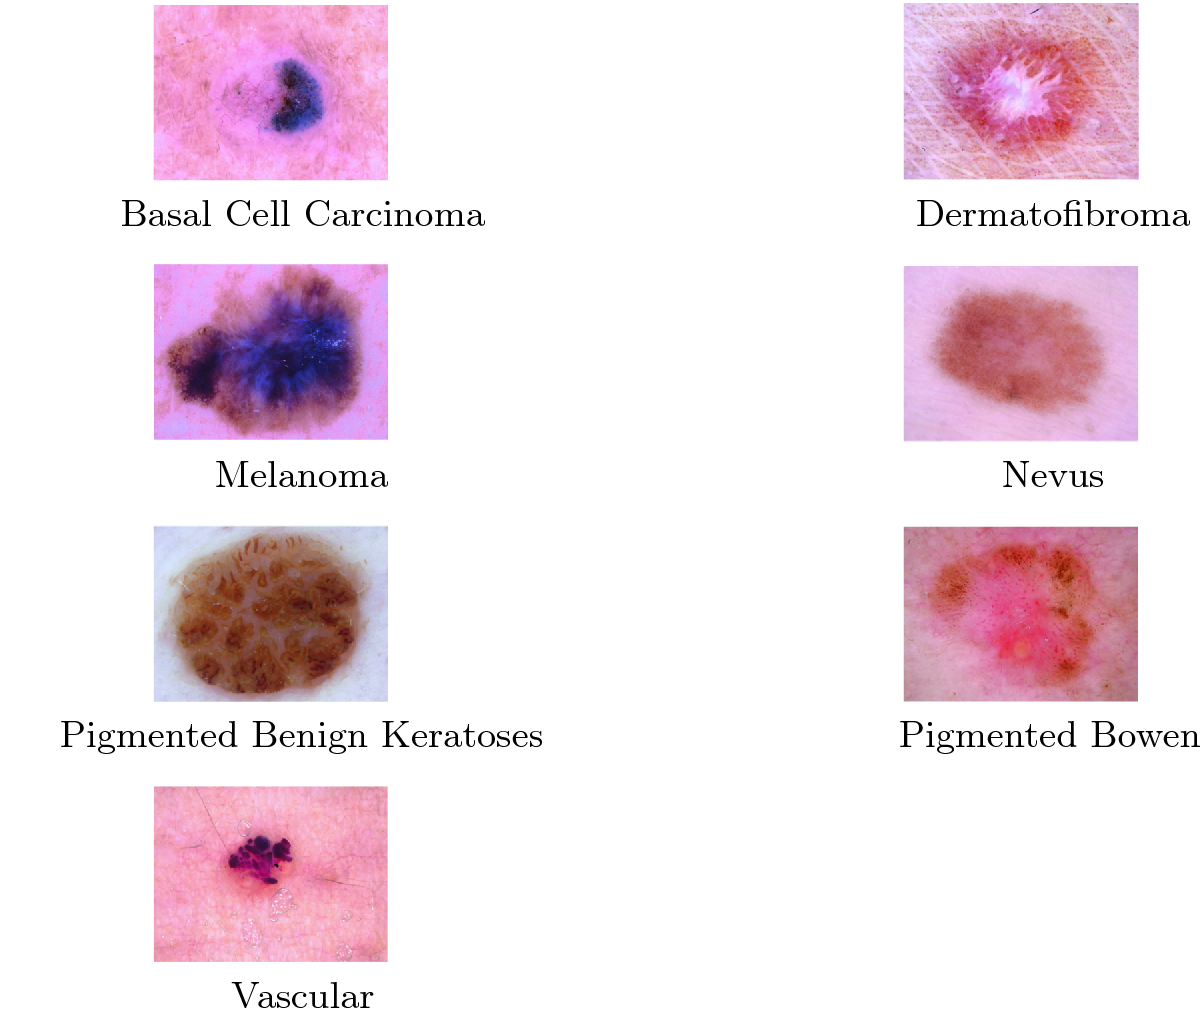


In [ ]:
%%capture
#Data directory: where the files will unzip to(destination folder) 
!mkdir data
!kaggle datasets download kmader/skin-cancer-mnist-ham10000 -p data
!apt install unzip
!mkdir HAM10000_images_part_1 
!mkdir HAM10000_images_part_2
!unzip /content/data/skin-cancer-mnist-ham10000.zip -d /content
# Unzip the whole zipfile into /content/data
!unzip /content/data/HAM10000_images_part_1.zip -d HAM10000_images_part_1 
!unzip /content/data/HAM10000_images_part_2.zip -d HAM10000_images_part_2
#Ouputs me how many files I unzipped
!echo files in /content/data: `ls data | wc -l`

In [ ]:
import os 
import errno
base_dir = 'base_dir'
image_class = ['nv','mel','bkl','bcc','akiec','vasc','df']
#3 folders are made: base_dir, train_dir and val_dir
try:
    os.mkdir(base_dir)
    
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass
train_dir = os.path.join(base_dir, 'train_dir')
try:
  os.mkdir(train_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass
val_dir = os.path.join(base_dir, 'val_dir')
try: 
  os.mkdir(val_dir)
  
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass
#make sub directories for the labels
for x in image_class:
      os.mkdir(train_dir+'/'+x)
for x in image_class:
      os.mkdir(val_dir+'/'+x)

In [ ]:
%%capture
#import libraries 
import pandas as pd
import shutil
df = pd.read_csv('/content/HAM10000_metadata.csv')
# Set y as the labels
y = df['dx']
y_valid = []
#split data
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.1, random_state=101, stratify=y)
# Transfer the images into folders, Set the image id as the index
image_index = df.set_index('image_id', inplace=True)
# Get a list of images in each of the two folders
folder_1 = os.listdir('HAM10000_images_part_1')
folder_2 = os.listdir('HAM10000_images_part_2')
# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
# Transfer the training images
for image in train_list:
  fname = image + '.jpg'
  if fname in folder_1:
          #the source path
          src = os.path.join('HAM10000_images_part_1', fname)
          
          #the destination path
          dst = os.path.join(train_dir+'/'+df['dx'][image], fname)
          print(dst)
          
          shutil.copyfile(src, dst)
  if fname in folder_2:
          #the source path
          src = os.path.join('HAM10000_images_part_2', fname)
          #the destination path
          dst = os.path.join(train_dir, fname)
          
          shutil.copyfile(src, dst)
# Transfer the validation images
for image in val_list:
  fname = image + '.jpg'
  if fname in folder_1:
          #the source path
          src = os.path.join('HAM10000_images_part_1', fname)
          #the destination path
          dst = os.path.join(val_dir+'/'+df['dx'][image], fname)
        
          shutil.copyfile(src, dst)
        
  if fname in folder_2:
          #the source path
          src = os.path.join('HAM10000_images_part_2', fname)
          # destination path to image
          dst = os.path.join(val_dir, fname)
          # copy the image from the source to the destination
          shutil.copyfile(src, dst)
          y_valid.append(df['dx'][image])
# Check how many training images are in train_dir
print(len(os.listdir('base_dir/train_dir')))
print(len(os.listdir('base_dir/val_dir')))
# Check how many validation images are in val_dir
# print(len(os.listdir('data/HAM10000_images_part_1')))
# print(len(os.listdir('data/HAM10000_images_part_2')))

## Some Diagrams to Better Understand Data

Text(0.5, 1.0, 'Numer of cases for each class')

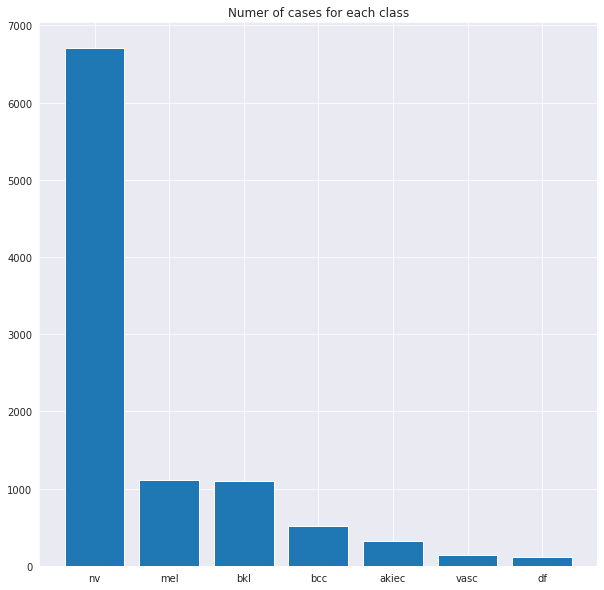

In [ ]:
plt.figure(figsize=(10,10))
metadata = pd.read_csv("/content/HAM10000_metadata.csv")
count = metadata['dx'].value_counts()
count = pd.DataFrame(count)
keys = count.to_dict()["dx"].keys()
values = count.to_dict()["dx"].values()
plt.bar(keys, values)
plt.title("Numer of cases for each class")

Text(0.5, 1.0, 'Numer of cases for each gender')

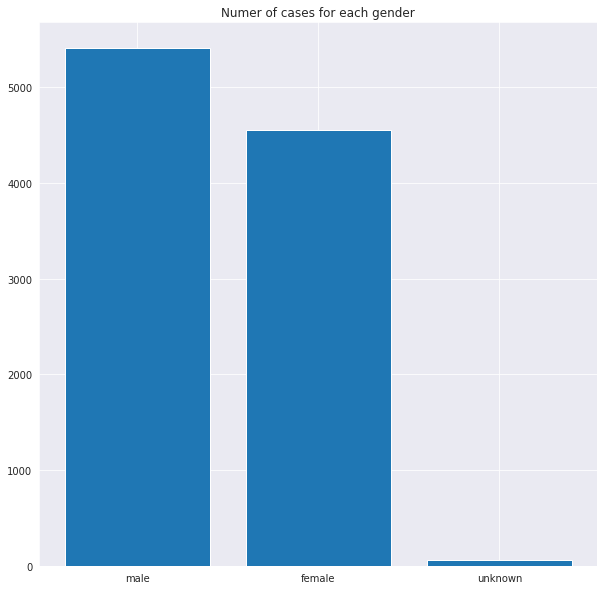

In [ ]:
plt.figure(figsize=(10,10))
count = metadata['sex'].value_counts()
count = pd.DataFrame(count)
keys = count.to_dict()["sex"].keys()
values = count.to_dict()["sex"].values()
plt.bar(keys, values)
plt.title("Numer of cases for each gender")

Text(0.5, 1.0, 'Numer of cases for each body part')

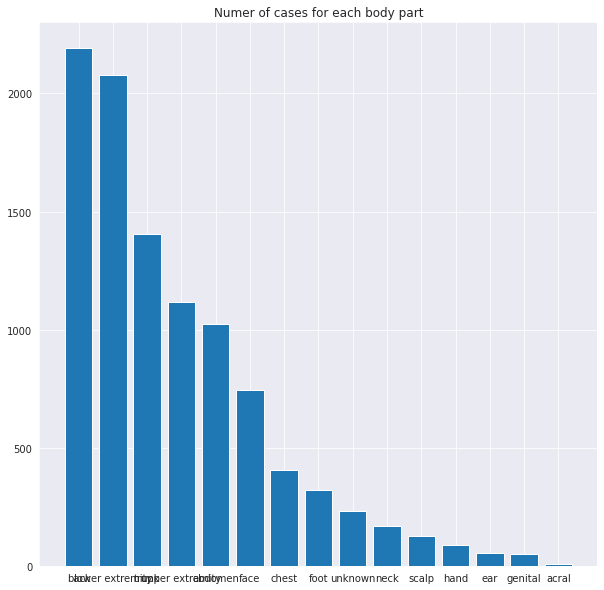

In [ ]:
plt.figure(figsize=(10,10))
count = metadata['localization'].value_counts()
count = pd.DataFrame(count)
keys = count.to_dict()["localization"].keys()
values = count.to_dict()["localization"].values()
plt.bar(keys, values)
plt.title("Numer of cases for each body part")

## Mobile Net

Mobilenets are class of efficient models for mobile and embedded vision applications. MobileNets are based on a stream lined architecture that uses depth-wise separable convolutions to build light weight deep neural networks todeal with resource and accuracy trade offs and it has shown strong performance compared to other popular models on ImageNet classification such as Inception. Since Mobilenet has depthwise convolution instead of reqular convolution it is lighter and faster to train and it can be used for mobile applications.



In [ ]:
#--------------image generator---------------
from keras.preprocessing.image import ImageDataGenerator
import keras 
print(df.head())
image_class = ['nv','mel','bkl','bcc','akiec','vasc','df']
train_path = 'base_dir/train_dir/'
valid_path = 'base_dir/val_dir/'
print(os.listdir('base_dir/train_dir'))
print(len(os.listdir('base_dir/val_dir')))
image_shape = 224
train_datagen  = ImageDataGenerator(rescale=1./255)
val_datagen  = ImageDataGenerator(rescale=1./255)
#declares data generator for train and val batches
train_batches = train_datagen.flow_from_directory(train_path, 
                                                        target_size = (image_shape,image_shape),
                                                        classes = image_class,
                                                        batch_size = 64
                                                        )
valid_batches = val_datagen.flow_from_directory(valid_path, 
                                                        target_size = (image_shape,image_shape),
                                                        classes = image_class,
                                                        batch_size = 64                                                      )

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten 
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model
mobile = keras.applications.mobilenet.MobileNet()
x = mobile.layers[-6].output
# Add a dropout and dense layer for predictions
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)
print(mobile.input)
net = Model(inputs=mobile.input, outputs=predictions)
mobile.summary()
for layer in net.layers[:-23]:
  layer.trainable = False
net.compile(optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.0001)
history = net.fit_generator(train_batches, epochs=5,validation_data=valid_batches)



# model.compile(SGD(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# history = model.fit_generator(train_batches, steps_per_epoch=10,
#                     validation_data=val_batches, validation_steps=10, epochs=300, verbose=2)




In [ ]:
from matplotlib import pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Getting layer weights


In [86]:
weights = net.layers[-1].get_weights()
weights[0].shape

(1024, 7)

#TDA

We used Kepler Mapper python package for topological data analysis phase
[link text](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiQ74CK_Z_tAhWLLewKHR6hBngQFjAAegQIARAD&url=https%3A%2F%2Fgithub.com%2Fscikit-tda%2Fkepler-mapper&usg=AOvVaw0eixlX2ZycRUw_F3DOBMO2)

In [89]:
pip install kmapper

     |████████████████████████████████| 102kB 4.2MB/s 


In [92]:
# from kmapper import jupyter
import kmapper as km
# import preprocessor as p
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler

In [ ]:
mapper = km.KeplerMapper(verbose=2)

projected_X = mapper.fit_transform(weights[0],
    projection=[ TruncatedSVD(n_components=100,
                             random_state=1729),
                Isomap(n_components=2,
                       n_jobs=-1)],
    scaler=[ None, MinMaxScaler()])

In [ ]:
                  #  clusterer=sklearn.cluster.DBSCAN(eps=0.1, min_samples=5),
                  #  cover=km.Cover(n_cubes=8, perc_overlap=0.5))


from sklearn import cluster
import sklearn
graph = mapper.map(projected_X,
                   clusterer=sklearn.cluster.DBSCAN(eps=0.1, min_samples=2),
                   cover=km.Cover(n_cubes=15, perc_overlap=0.3))

In [ ]:
html = mapper.visualize(graph,
                        path_html="newsgroups20.html",
                        custom_tooltips=weights[0])
                        

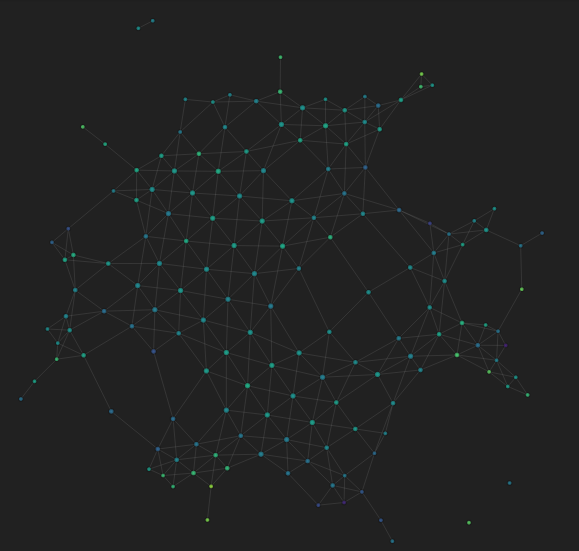